<a href="https://colab.research.google.com/github/apallath/cats_vs_dogs_models/blob/main/cats_vs_dogs_filter_grad_ascent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
import os, shutil
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input

# Fine-tuned ResNet50 activations

In [3]:
model = load_model('/content/drive/MyDrive/colab_models/cats_vs_dogs_resnet50_fine_tuned.h5')
model.layers[0].summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [4]:
# Layers to extract features from
layer_names = ['conv2_block3_out', 'conv3_block4_out']

# Visualize first X filters
first_filters = [16, 16]

layers = [model.layers[0].get_layer(name=layer_name) for layer_name in layer_names]
feature_extractor = keras.Model(inputs=model.layers[0].inputs, outputs=[layer.output for layer in layers])

In [10]:
def compute_loss(img, layer_index, filter_index):
    activations = feature_extractor(img)

    # Exclude edge layers to avoid border artifacts
    filter_activation = activations[layer_index][..., 2:-2, 2:-2, filter_index]
    print(np.shape(filter_activation))
    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(img, layer_index, filter_index, lr):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, layer_index, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    # Step
    img += lr * grads
    return loss, img

"""
def process_image(img):
    # Perform 'caffe' style normalization'
    # Convert from RGB to BGR
    img = img[..., ::-1]

    # Mean shift
    mean = [103.939, 116.779, 123.68]
    img[...,0] -= mean[0]
    img[...,1] -= mean[1]
    img[...,2] -= mean[2]

    return img
"""

def deprocess_image(img):
    # Undo 'caffe' style normalization
    # Mean shift
    # Weights from keras source code
    mean = [103.939, 116.779, 123.68]
    img[...,0] += mean[0]
    img[...,1] += mean[1]
    img[...,2] += mean[2]

    # Convert from BGR to RGB
    img = img[..., ::-1]

    # Clip activations in [0, 1]
    return np.clip(img, 0, 1)

def initialize_image():
    # Gray image with some random noise
    x = tf.random.uniform((1, 150, 150, 3))
    img = preprocess_input(x) #caffe style preprocessing
    return img

def visualize_filter(layer_index, filter_index):
    # 30 steps
    steps = 30
    lr = 10.0
    img = initialize_image()
    for step in range(steps):
        loss, img = gradient_ascent_step(img, layer_index, filter_index, lr)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img

Layer 0, filter 0
(1, 34, 34)
Layer 0, filter 1
(1, 34, 34)
Layer 0, filter 2
(1, 34, 34)
Layer 0, filter 3
(1, 34, 34)
Layer 0, filter 4
(1, 34, 34)
Layer 0, filter 5
(1, 34, 34)
Layer 0, filter 6
(1, 34, 34)
Layer 0, filter 7
(1, 34, 34)
Layer 0, filter 8
(1, 34, 34)
Layer 0, filter 9
(1, 34, 34)
Layer 0, filter 10
(1, 34, 34)
Layer 0, filter 11
(1, 34, 34)
Layer 0, filter 12
(1, 34, 34)
Layer 0, filter 13
(1, 34, 34)
Layer 0, filter 14
(1, 34, 34)
Layer 0, filter 15
(1, 34, 34)
Layer 1, filter 0
(1, 15, 15)
Layer 1, filter 1
(1, 15, 15)
Layer 1, filter 2
(1, 15, 15)
Layer 1, filter 3
(1, 15, 15)
Layer 1, filter 4
(1, 15, 15)
Layer 1, filter 5
(1, 15, 15)
Layer 1, filter 6
(1, 15, 15)
Layer 1, filter 7
(1, 15, 15)
Layer 1, filter 8
(1, 15, 15)
Layer 1, filter 9
(1, 15, 15)
Layer 1, filter 10
(1, 15, 15)
Layer 1, filter 11
(1, 15, 15)
Layer 1, filter 12
(1, 15, 15)
Layer 1, filter 13
(1, 15, 15)
Layer 1, filter 14
(1, 15, 15)
Layer 1, filter 15
(1, 15, 15)


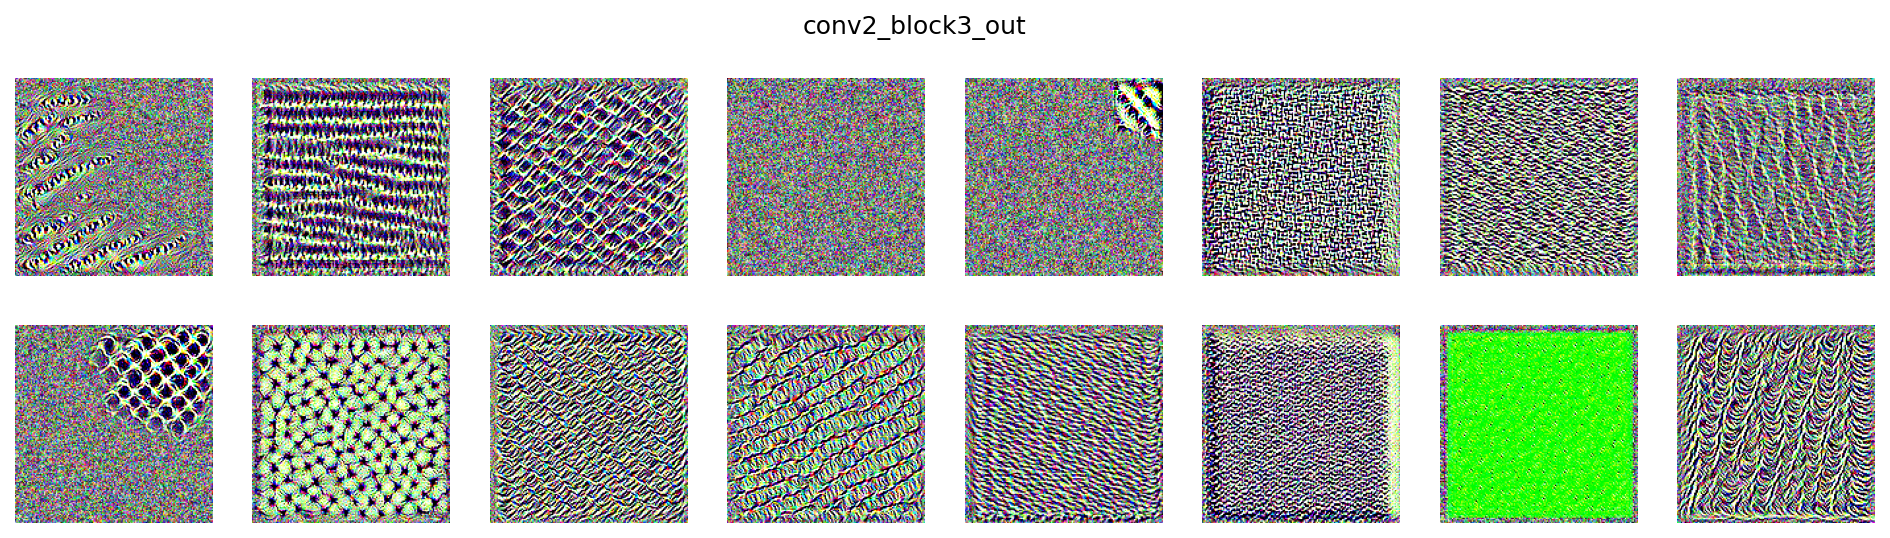

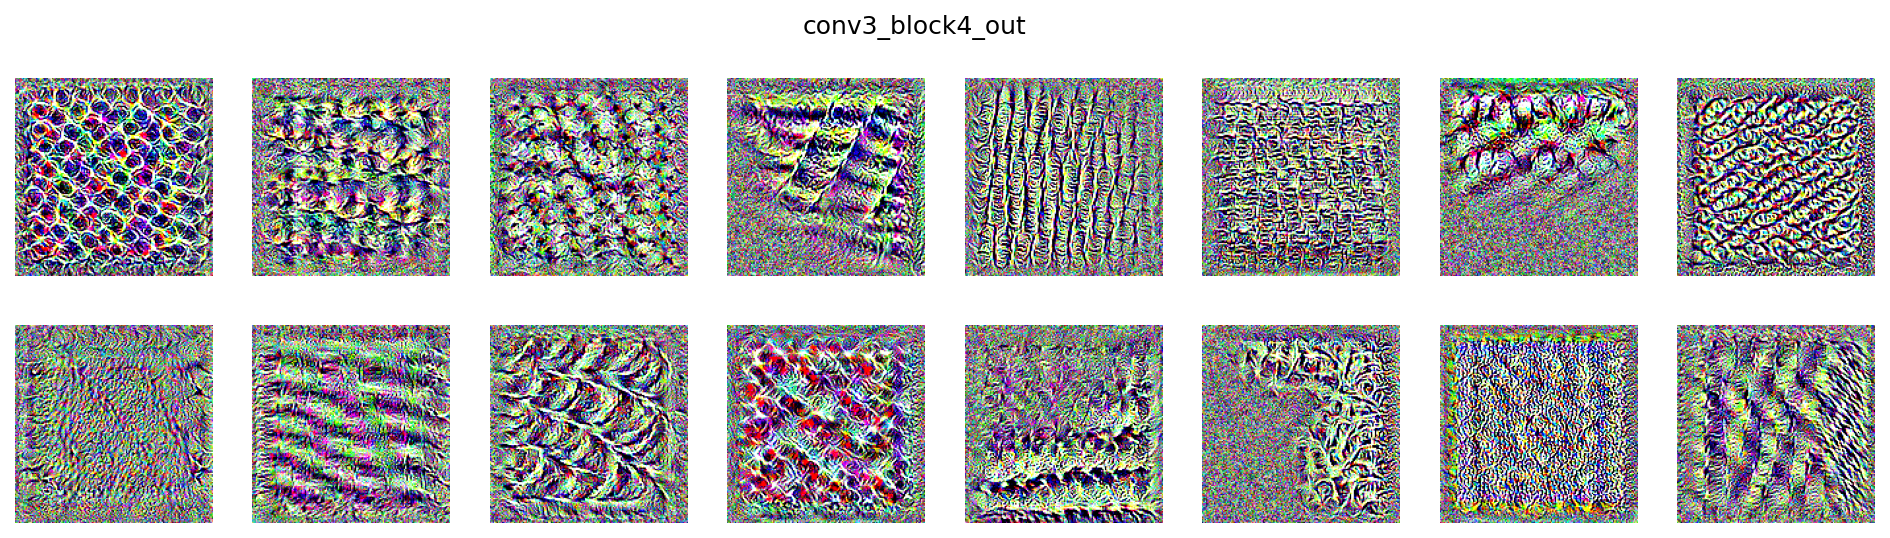

In [11]:
n_cols = 8

for layer_index in range(len(layers)):
    n_filters = first_filters[layer_index]
    n_rows = int(np.ceil(n_filters / n_cols))

    fig = plt.figure(figsize=(2 * n_cols, 2 * n_rows), dpi=150)
    for filter_index in range(n_filters):
        print("Layer {}, filter {}".format(layer_index, filter_index))
        loss, img = visualize_filter(layer_index, filter_index)

        ax = plt.subplot(n_rows, n_cols, filter_index + 1, adjustable='box', aspect=1)
        ax.imshow(img)
        ax.axis('off')

    fig.suptitle(layer_names[layer_index])